In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preproccessing

We will try to handle fill values, many values in SWISS dataset has beem filled with -1e31.
We will use rolling mean to fill in missing values and standard scale the values

## Importing libraries and handling fill values

In [4]:
import pandas as pd
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
import gc

# Path to your labeled HDF5
LABELED_DATA_PATH = '/content/drive/MyDrive/adtiya l1/sw_level2_full.h5'

# Fill value used in SWIS data
FILL_VALUE = -1e31


## Loading 1 and 2 Dimentional Data

In [7]:
import warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
import h5py

# Suppress all warnings (including numpy runtime warnings)
warnings.filterwarnings('ignore')

def load_swis_h5(filepath):
    """
    Load only 1D & 2D SWIS variables from HDF5, with a progress bar and
    without any printed warnings. 2D arrays are summarized by mean/std.
    """
    dfs = []
    with h5py.File(filepath, 'r') as hf:
        # Wrap the date-key loop in tqdm for a progress bar
        for date_key in tqdm(hf.keys(), desc="Loading dates"):
            if date_key == 'stats':
                continue
            grp = hf[date_key]
            if 'utc_time_ms' not in grp or 'label_code' not in grp:
                continue

            # Read time and label
            t_ms  = grp['utc_time_ms'][:]
            times = pd.to_datetime(t_ms, unit='ms', utc=True)
            df    = pd.DataFrame({
                'time':       times,
                'label_code': grp['label_code'][:]
            }).set_index('time')

            # Instruments
            for inst in ('BLK','TH1','TH2'):
                if inst not in grp:
                    continue
                for var, ds in grp[inst].items():
                    # Skip scalars
                    if ds.ndim == 0:
                        continue
                    data = ds[:]
                    # 1D → direct
                    if ds.ndim == 1 and data.shape[0] == len(df):
                        df[f'{inst}/{var}'] = data.astype(np.float32)
                    # 2D → summarize
                    elif ds.ndim == 2 and data.shape[0] == len(df):
                        df[f'{inst}/{var}_mean'] = np.nanmean(data, axis=1).astype(np.float32)
                        df[f'{inst}/{var}_std']  = np.nanstd(data, axis=1).astype(np.float32)
                    # otherwise: skip silently

            dfs.append(df)

    if not dfs:
        return pd.DataFrame()

    full = pd.concat(dfs).sort_index()
    full['is_halo_cme_event'] = full['label_code'] > 0
    return full

# Usage
labeled_swis_df = load_swis_h5(LABELED_DATA_PATH)
print(f"\nLoaded DataFrame: {labeled_swis_df.shape[0]} rows × {labeled_swis_df.shape[1]} columns")


Loading dates: 100%|██████████| 311/311 [03:57<00:00,  1.31it/s]



Loaded DataFrame: 5119116 rows × 53 columns


## Replacing fill values with NaN

In [8]:
num_cols = [c for c in labeled_swis_df if
            pd.api.types.is_numeric_dtype(labeled_swis_df[c])
            and c not in ('label_code','is_halo_cme_event')]

labeled_swis_df[num_cols] = labeled_swis_df[num_cols]\
    .replace(FILL_VALUE, np.nan)

print("NaNs after fill-value replacement:", labeled_swis_df[num_cols].isna().sum().sum())


NaNs after fill-value replacement: 1013686


## Feature Engineering by Rolling Statistics

In [9]:
# 1) Dynamic pressure
if all(x in labeled_swis_df for x in ('BLK/proton_density','BLK/proton_bulk_speed')):
    labeled_swis_df['dynamic_pressure'] = (
        1.67e-6
        * labeled_swis_df['BLK/proton_density']
        * labeled_swis_df['BLK/proton_bulk_speed']**2
    )

# 2) Rolling stats (30 min)
ROLL = '30min'
features = [
    'BLK/proton_density','BLK/proton_bulk_speed','BLK/proton_thermal',
    'BLK/alpha_density','BLK/alpha_bulk_speed','dynamic_pressure'
]
for col in features:
    if col in labeled_swis_df:
        r = labeled_swis_df[col].rolling(ROLL, min_periods=1)
        labeled_swis_df[f'{col}_mean_{ROLL}'] = r.mean().astype('float32')
        labeled_swis_df[f'{col}_std_{ROLL}']  = r.std().astype('float32')

# 3) Gradients
for col in features:
    if col in labeled_swis_df:
        labeled_swis_df[f'{col}_grad'] = labeled_swis_df[col]\
            .diff().astype('float32')

print("After feature eng’n, columns:", [c for c in labeled_swis_df.columns if 'dynamic_pressure' in c])


After feature eng’n, columns: ['dynamic_pressure', 'dynamic_pressure_mean_30min', 'dynamic_pressure_std_30min', 'dynamic_pressure_grad']


## Missing-Value Interpolation

In [10]:
# Linear interpolate inside gaps, then back-/forward-fill edges
for col in num_cols + ['dynamic_pressure']:
    if col in labeled_swis_df:
        s = labeled_swis_df[col]
        s = s.interpolate(method='linear', limit_direction='both')
        s = s.fillna(method='bfill').fillna(method='ffill')
        labeled_swis_df[col] = s

print("Remaining NaNs:", labeled_swis_df[num_cols].isna().sum().sum())


Remaining NaNs: 0


## Removing infinite values and Cleaning

In [11]:
# --- Robust Infinity & Persistent-NaN Handling ---
print("\n--- Robust Handling: Infinity and Persistent NaN Values ---")

# 1) Identify all numeric feature columns (exclude labels)
num_feats = [
    c for c in labeled_swis_df.select_dtypes(include=np.number).columns
    if c not in ('label_code','is_halo_cme_event')
]

# 2) Replace infinities with NaN
inf_counts = labeled_swis_df[num_feats].isin([np.inf, -np.inf]).sum()
total_inf = int(inf_counts.sum())
if total_inf > 0:
    print(f"Found {total_inf} infinite values; replacing with NaN…")
    labeled_swis_df[num_feats] = labeled_swis_df[num_feats] \
        .replace([np.inf, -np.inf], np.nan)
else:
    print("No infinities detected.")

# 3) Re-apply interpolation + edge filling
for col in num_feats:
    s = labeled_swis_df[col]
    # linear interp in the middle
    s = s.interpolate(method='linear', limit_direction='both', limit_area='inside')
    # fill any remaining leading/trailing NaNs
    s = s.fillna(method='bfill').fillna(method='ffill')
    labeled_swis_df[col] = s

# 4) Drop any columns still containing non-finite values
bad = [c for c in num_feats if not np.isfinite(labeled_swis_df[c]).all()]
if bad:
    print(f"Dropping columns with unfixable values: {bad}")
    labeled_swis_df.drop(columns=bad, inplace=True)
else:
    print("All numeric features are now finite and clean!")



--- Robust Handling: Infinity and Persistent NaN Values ---
Found 3978532 infinite values; replacing with NaN…
All numeric features are now finite and clean!


## Scalling

In [12]:
# --- Step 3: Feature Scaling ---

from sklearn.preprocessing import StandardScaler

# 1) Identify numeric features (exclude labels)
features_to_scale = [
    c for c in labeled_swis_df.select_dtypes(include=np.number).columns
    if c not in ('label_code','is_halo_cme_event')
]

# 2) Drop any constant (zero‐variance) features
constant_feats = [c for c in features_to_scale if labeled_swis_df[c].std() == 0]
if constant_feats:
    print(f"Dropping constant features: {constant_feats}")
    labeled_swis_df.drop(columns=constant_feats, inplace=True)
    features_to_scale = [c for c in features_to_scale if c not in constant_feats]

# 3) Initialize and fit‐transform with StandardScaler
scaler = StandardScaler()
labeled_swis_df[features_to_scale] = scaler.fit_transform(labeled_swis_df[features_to_scale])

# 4) Verification (mean ≈ 0, std ≈ 1)
for col in features_to_scale[:5]:  # show first 5 for brevity
    m = labeled_swis_df[col].mean()
    s = labeled_swis_df[col].std()
    print(f"{col:40s} → mean: {m:.4f}, std: {s:.4f}")


BLK/alpha_bulk_speed                     → mean: -0.0000, std: 1.0000
BLK/alpha_density                        → mean: 0.0000, std: 1.0000
BLK/alpha_thermal                        → mean: -0.0000, std: 1.0000
BLK/bulk_a_uncer                         → mean: 0.0000, std: 1.0000
BLK/bulk_p_uncer                         → mean: 0.0000, std: 1.0000


## Displaying Scaled Values

In [13]:
# --- Step 4: Display Scaled Feature Sample & Verification ---

# 1) Define which columns to show
display_cols = [
    'BLK/proton_density',
    'BLK/proton_density_rolling_mean_30min',
    'BLK/proton_density_gradient',
    'dynamic_pressure',
    'dynamic_pressure_rolling_mean_30min',
    'dynamic_pressure_gradient',
    'is_halo_cme_event'
]

# 2) Filter to only the columns that actually exist
display_cols = [c for c in display_cols if c in labeled_swis_df.columns]

# 3) Print header
print("Features have been successfully scaled using StandardScaler.\n")
print("First 5 rows of DataFrame after Feature Scaling (showing examples):")

# 4) Show the slice
print(labeled_swis_df[display_cols].head().to_string())

# 5) Verification: mean & std of one key feature
feat = 'BLK/proton_density'
if feat in labeled_swis_df:
    m = labeled_swis_df[feat].mean()
    s = labeled_swis_df[feat].std()
    print(f"\nVerification: Mean of '{feat}' after scaling: {m:.4f}")
    print(f"Verification: Standard Deviation of '{feat}' after scaling: {s:.4f}")


Features have been successfully scaled using StandardScaler.

First 5 rows of DataFrame after Feature Scaling (showing examples):
                                  BLK/proton_density  dynamic_pressure  is_halo_cme_event
time                                                                                     
2024-08-01 00:00:27.619000+00:00           -0.796637          0.006217               True
2024-08-01 00:00:32.619000+00:00           -0.796637          0.006217               True
2024-08-01 00:00:37.619000+00:00           -0.796637          0.006217               True
2024-08-01 00:00:42.619000+00:00           -0.796637          0.006217               True
2024-08-01 00:00:47.619000+00:00           -0.796637          0.006217               True

Verification: Mean of 'BLK/proton_density' after scaling: 0.0000
Verification: Standard Deviation of 'BLK/proton_density' after scaling: 1.0000


In [14]:
# --- Step X: Downcast to float32 & Print Memory Usage ---

# 1) Identify numeric columns (exclude labels)
numeric_cols = [
    c for c in labeled_swis_df.select_dtypes(include=np.number).columns
    if c not in ('label_code', 'is_halo_cme_event')
]

# 2) Measure memory before downcast
mem_before = labeled_swis_df[numeric_cols].memory_usage(deep=True).sum() / (1024**2)

# 3) Downcast each column to float32
for col in numeric_cols:
    labeled_swis_df[col] = labeled_swis_df[col].astype(np.float32)

# 4) Measure memory after downcast
mem_after = labeled_swis_df[numeric_cols].memory_usage(deep=True).sum() / (1024**2)

# 5) Report
print(f"Memory usage BEFORE downcast: {mem_before:.2f} MB")
print(f"Memory usage AFTER  downcast: {mem_after:.2f} MB")
print(f"Reduction: {mem_before - mem_after:.2f} MB ({100*(mem_before-mem_after)/mem_before:.1f}% decrease)")


Memory usage BEFORE downcast: 2772.96 MB
Memory usage AFTER  downcast: 1406.01 MB
Reduction: 1366.95 MB (49.3% decrease)


# Random Forest

# Data Splitting

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# No need for StandardScaler import here, as it was already applied.

print("\n--- Step 4: Data Splitting for Time Series ---")

# Separate features (X) and target (y)
# Features will be all numerical columns that were scaled, excluding the label.
# The target is 'is_halo_cme_event'.

# Get all columns except 'label_code' (raw label) and 'is_halo_cme_event' (binary label)
# and the original 'time' index if it became a regular column during some operation.
feature_columns = labeled_swis_df.select_dtypes(include=np.number).columns.tolist()
if 'label_code' in feature_columns:
    feature_columns.remove('label_code')
if 'is_halo_cme_event' in feature_columns:
    feature_columns.remove('is_halo_cme_event')

# Ensure the columns actually exist in the DataFrame after all previous dropping steps
# (e.g., if dynamic_pressure was dropped, don't try to include it)
feature_columns = [col for col in feature_columns if col in labeled_swis_df.columns]


X = labeled_swis_df[feature_columns]
y = labeled_swis_df['is_halo_cme_event']

print(f"Number of features (X): {X.shape[1]}")
print(f"Number of samples (total): {X.shape[0]}")
print(f"Target (y) shape: {y.shape}")

# Perform a chronological split
# We'll use a standard 80% for training and 20% for testing.
# For time series, this means taking the first 80% of rows for training
# and the last 20% for testing.
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Train set period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test set period: {X_test.index.min()} to {X_test.index.max()}")

print("\nData splitting complete.")


--- Step 4: Data Splitting for Time Series ---
Number of features (X): 70
Number of samples (total): 5119116
Target (y) shape: (5119116,)

Training set size: 4095292 samples
Testing set size: 1023824 samples
Train set period: 2024-08-01 00:00:27.619000+00:00 to 2025-04-22 06:19:29.406000+00:00
Test set period: 2025-04-22 06:19:34.406000+00:00 to 2025-06-26 23:59:56.929000+00:00

Data splitting complete.


## Model Initialization 

In [ ]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

print("\n--- Step 5: Addressing Class Imbalance & Baseline Model Selection ---")

# 1. Analyze Class Distribution
print("\nClass distribution in the Training Set (y_train):")
print(y_train.value_counts())
print("\nClass distribution in the Testing Set (y_test):")
print(y_test.value_counts())

# Calculate the proportion of the minority class
minority_class_proportion_train = y_train.value_counts(normalize=True)[True]
print(f"\nProportion of Halo CME events (True) in Training Set: {minority_class_proportion_train:.4f}")

if minority_class_proportion_train < 0.10: # Example threshold for considering highly imbalanced
    print("Warning: The dataset is highly imbalanced. Using `class_weight='balanced'` is crucial.")
else:
    print("Class imbalance detected. `class_weight='balanced'` will be applied.")


# 2. Baseline Model Selection: Random Forest Classifier
print("\nSelecting Random Forest Classifier as the baseline model.")
print("Using `class_weight='balanced'` to handle class imbalance.")

# Initialize the Random Forest Classifier
# n_estimators: number of trees in the forest
# random_state: for reproducibility
# class_weight='balanced': automatically adjusts weights based on class frequencies
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1) # n_jobs=-1 uses all available cores

print("Random Forest Classifier model initialized.")

# Continue to training in the next step.

## Training and Testing


--- Step 6: Model Training and Initial Evaluation ---
Training Random Forest Classifier (this may take some time due to data size)...
Model training complete in 720.12 seconds.

Making predictions on the test set...

--- Model Evaluation on Test Set ---

Classification Report:
              precision    recall  f1-score   support

      No CME       0.80      0.97      0.88    823348
         CME       0.21      0.03      0.06    200476

    accuracy                           0.79   1023824
   macro avg       0.51      0.50      0.47   1023824
weighted avg       0.69      0.79      0.72   1023824


ROC AUC Score: 0.4921
Precision-Recall AUC: 0.1938

Confusion Matrix:


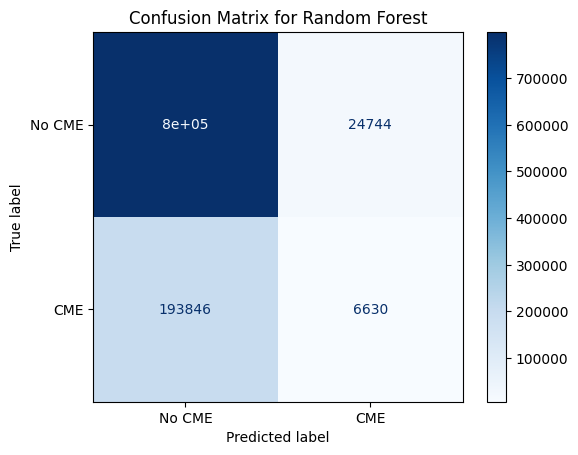


Predicted True (CME) count: 31374
Predicted False (No CME) count: 992450
Actual True (CME) count: 200476
Actual False (No CME) count: 823348

Initial model evaluation complete.


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay # For visualizing confusion matrix
)
import time # To measure training time

print("\n--- Step 6: Model Training and Initial Evaluation ---")

# 1. Train the Random Forest Model
print("Training Random Forest Classifier (this may take some time due to data size)...")
start_time = time.time()

rf_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Model training complete in {training_time:.2f} seconds.")

# 2. Make Predictions on the Test Set
print("\nMaking predictions on the test set...")
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (True)

# 3. Evaluate Performance
print("\n--- Model Evaluation on Test Set ---")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No CME', 'CME']))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
# Using ConfusionMatrixDisplay for better readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No CME', 'CME'])
disp.plot(cmap='Blues')
import matplotlib.pyplot as plt # Import matplotlib to show the plot
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Quick sanity check on prediction counts
print(f"\nPredicted True (CME) count: {np.sum(y_pred == True)}")
print(f"Predicted False (No CME) count: {np.sum(y_pred == False)}")
print(f"Actual True (CME) count: {np.sum(y_test == True)}")
print(f"Actual False (No CME) count: {np.sum(y_test == False)}")

print("\nInitial model evaluation complete.")